<a href="https://colab.research.google.com/github/WayneGretzky1/nba_game_predictor/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
torch.set_printoptions(sci_mode=False)

In [52]:
nba_df = pd.read_csv("https://raw.githubusercontent.com/WayneGretzky1/nba_game_predictor/refs/heads/main/cleaned_w_rest.csv")
nba_df.head()

,22100127,2021-11-05,1610612761,1610612739,false,true,0.4,0.6,102.8,99.4,...,0.7074,0.775,46.2,47.6,20,16,14.4,17.4,true.1,true.2
0,22100137,2021-11-06,1610612756,1610612737,True,False,0.6,0.2,108.2,102.0,...,0.7802,0.7342,48.2,50.6,17.8,17.2,15.0,13.2,True,True
1,22100145,2021-11-07,1610612744,1610612745,True,False,0.8,0.0,111.8,102.6,...,0.6820,0.6300,51.8,46.4,18.2,19.4,17.6,21.0,True,False
2,22100150,2021-11-08,1610612742,1610612740,True,False,0.8,0.2,108.4,96.0,...,0.6490,0.8328,44.2,49.2,20.0,18.4,12.6,20.8,True,True
3,22100154,2021-11-08,1610612747,1610612766,True,False,0.8,0.2,110.4,105.4,...,0.7542,0.7388,42.6,39.6,18.8,17.0,16.8,13.4,True,False
4,22100147,2021-11-08,1610612755,1610612752,False,True,0.8,0.8,111.4,111.8,...,0.8542,0.7330,37.4,45.8,20.2,19.4,13.6,12.2,True,True


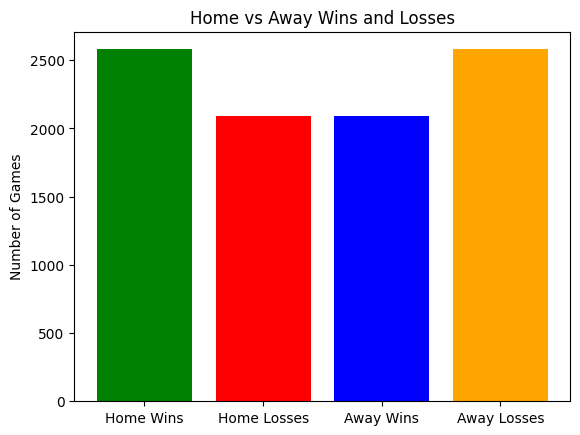

home_wins 2580
home_losses 2094
away_wins 2094
away_losses 2580


In [3]:
home_wins = nba_df['home_win'].sum()
home_losses = len(nba_df) - home_wins
away_wins = nba_df['away_win'].sum()
away_losses = len(nba_df) - away_wins

categories = ['Home Wins', 'Home Losses', 'Away Wins', 'Away Losses']
counts = [home_wins, home_losses, away_wins, away_losses]

plt.bar(categories, counts, color=['green', 'red', 'blue', 'orange'])
plt.title('Home vs Away Wins and Losses')
plt.ylabel('Number of Games')
plt.show()
print("home_wins", home_wins)
print("home_losses", home_losses)
print("away_wins", away_wins)
print("away_losses", away_losses)


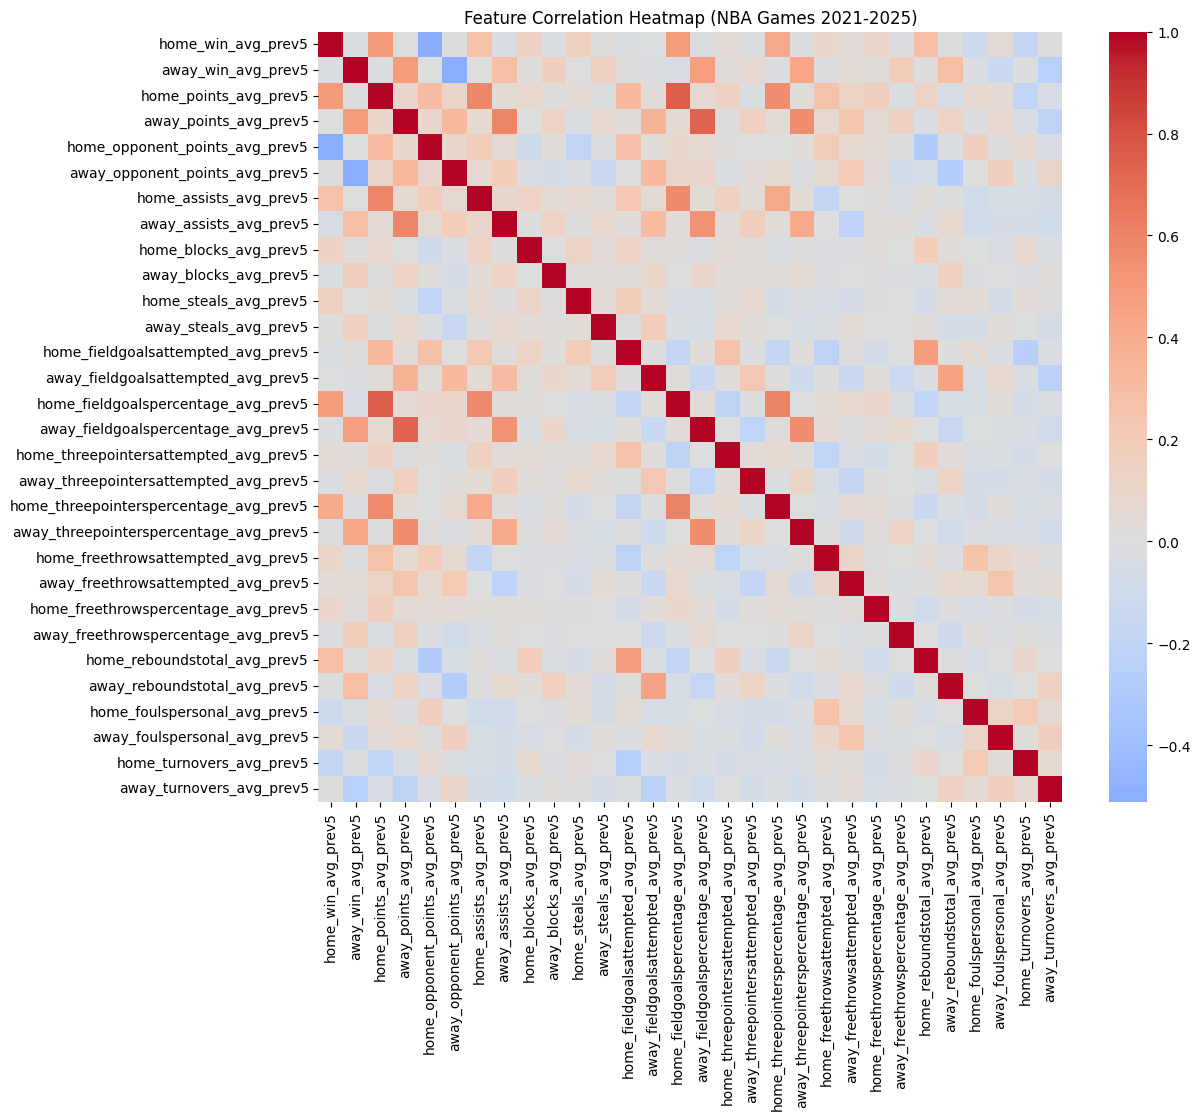

home_win                                  1.000000
home_win_avg_prev5                        0.184739
home_points_avg_prev5                     0.123951
home_fieldgoalspercentage_avg_prev5       0.120506
away_opponent_points_avg_prev5            0.101748
away_turnovers_avg_prev5                  0.099319
home_threepointerspercentage_avg_prev5    0.085131
home_assists_avg_prev5                    0.057525
home_reboundstotal_avg_prev5              0.053338
away_foulspersonal_avg_prev5              0.044725
home_steals_avg_prev5                     0.041555
home_threepointersattempted_avg_prev5     0.036452
home_freethrowsattempted_avg_prev5        0.035001
home_blocks_avg_prev5                     0.019877
home_freethrowspercentage_avg_prev5       0.014906
away_freethrowsattempted_avg_prev5        0.014709
away_fieldgoalsattempted_avg_prev5        0.006906
home_fieldgoalsattempted_avg_prev5       -0.011663
away_blocks_avg_prev5                    -0.026607
home_foulspersonal_avg_prev5   

In [4]:
feature_df = nba_df.drop(columns=['home_win', 'away_win', 'gameid', 'gamedate', 'home_teamid', 'away_teamid'])
corr_matrix = feature_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (NBA Games 2021-2025)")
plt.show()
# print(corr_matrix.round(3))
# strong_corr = corr_matrix[(corr_matrix.abs() > 0.5) & (corr_matrix.abs() < 1.0)]
# print(strong_corr.round(3))
feature_df = nba_df.drop(columns=[ 'away_win', 'gameid', 'gamedate', 'home_teamid', 'away_teamid'])

label_corr = feature_df.corr()['home_win'].sort_values(ascending=False)
print(label_corr)


In [5]:
#choose features X and label y
X = nba_df.drop(columns=['home_win', 'away_win', 'gameid', 'gamedate', 'home_teamid', 'away_teamid']).to_numpy() #every col except these
y = nba_df['home_win'].to_numpy()

In [6]:
#train-test split
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [7]:
#normalize with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)
# print(X_train_norm)

In [8]:
#PyTorch Dataset class
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).long()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [9]:
#Convert to PyTorch Dataset
training_dataset = NumpyDataset(X_train_norm, y_train)
validation_dataset = NumpyDataset(X_val_norm, y_val)
testing_dataset = NumpyDataset(X_test_norm, y_test)


In [10]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

def evaluate(model, data_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      avg_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  avg_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return avg_loss

def logResults(epoch, num_epochs, train_loss, val_loss, train_loss_history, val_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Val Loss: %.4f' %(epoch+1, num_epochs, train_loss, val_loss))
  train_loss_history.append(train_loss)
  val_loss_history.append(val_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, val_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], val_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(model, training_generator, validation_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  val_loss_history  = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_train_loss  = train(model, training_generator, loss_function, optimizer)
    val_loss = evaluate(model, validation_generator, loss_function)
    logResults(epoch, num_epochs, avg_train_loss, val_loss, train_loss_history, val_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, val_loss_history)
  test_loss = evaluate(model, testing_generator, loss_function)
  print(f"\nFinal Test Loss: {test_loss:.4f}")

def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum().item()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [41]:
class Classifier_3Layers(nn.Module):
    def __init__(self, input_dim, numClasses=2):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 32)
        self.linear2 = nn.Linear(32, 16)
        self.linear3 = nn.Linear(16, 8)
        self.linear4 = nn.Linear(8, numClasses)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

Loaded Data
Epoch [1/30], Train Loss: 0.6906, Val Loss: 0.6894
Epoch [6/30], Train Loss: 0.6625, Val Loss: 0.6565
Epoch [11/30], Train Loss: 0.6418, Val Loss: 0.6505
Epoch [16/30], Train Loss: 0.6317, Val Loss: 0.6522
Epoch [21/30], Train Loss: 0.6204, Val Loss: 0.6552
Epoch [26/30], Train Loss: 0.6077, Val Loss: 0.6611

Final Test Loss: 0.6576


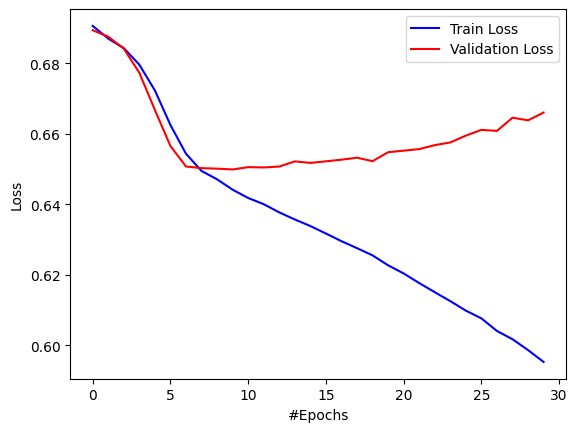

In [42]:
#Training parameters
num_epochs = 30
learning_rate = 0.001
batch_size = 200
print_interval = 5

input_dim = X_train_norm.shape[1]

#Create model
model = Classifier_3Layers(input_dim, numClasses=2)

#Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_generator = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

# trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)
trainAndGraph(model, training_generator, validation_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)


In [43]:
computeLabelAccuracy(model, training_generator, "Train Set")
computeLabelAccuracy(model, validation_generator, "Validation Set")
computeLabelAccuracy(model, testing_generator, "Test Set")


Train Set: Accuracy: 2103/2991 (70.3%)

Validation Set: Accuracy: 463/748 (61.9%)

Test Set: Accuracy: 566/935 (60.5%)


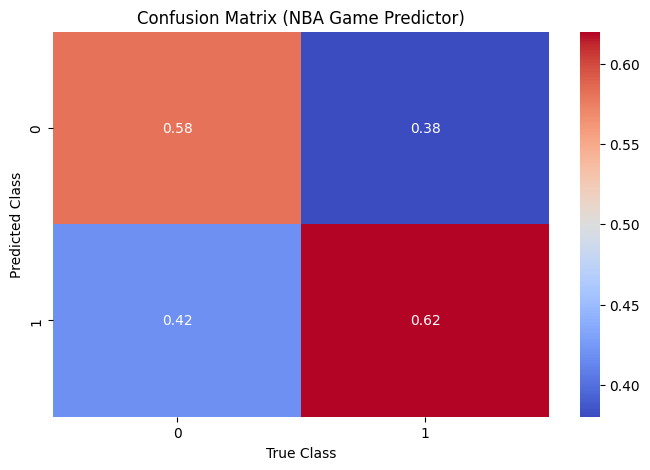

[[0.58119658 0.38013699]
 [0.41880342 0.61986301]]


In [44]:
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (features,labels) = next(data_enumerator)
with torch.no_grad():
    outputs = model(features)
    pred_labels = outputs.data.max(1, keepdim=True)[1].squeeze() #only the highest value is the final prediction
    true_labels = labels
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "coolwarm") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix (NBA Game Predictor)")
plt.show()
print(conf_mat)

In [45]:
y_true = true_labels.numpy()
y_pred = pred_labels.numpy()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.6198630136986302
Recall: 0.7111984282907662
F1-score: 0.6623970722781336


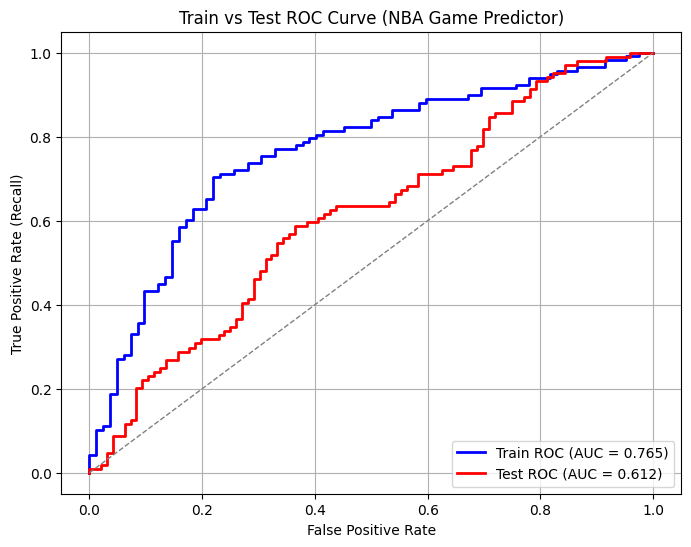

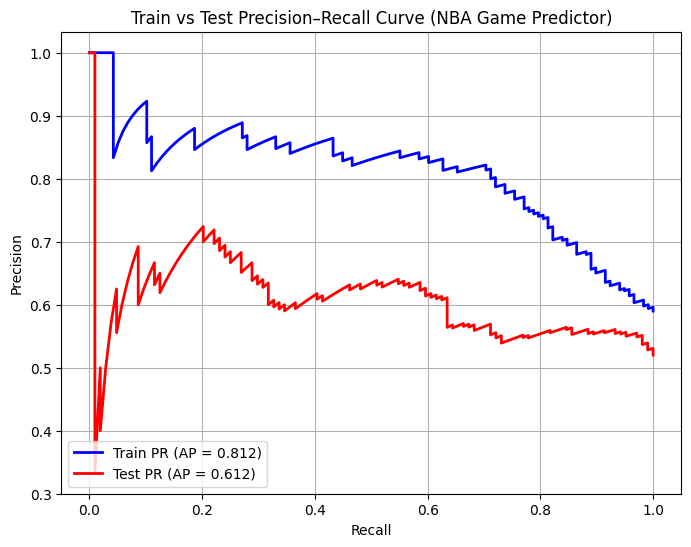

In [46]:
_, (train_features, train_labels) = next(enumerate(training_generator))
_, (test_features, test_labels) = next(enumerate(testing_generator))

with torch.no_grad():
    train_outputs = model(train_features)
    y_train_scores = torch.softmax(train_outputs, dim=1)[:,1].numpy()
    y_train_true = train_labels.numpy()

    test_outputs = model(test_features)
    y_test_scores = torch.softmax(test_outputs, dim=1)[:,1].numpy()
    y_test_true = test_labels.numpy()


fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_scores)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {roc_auc_train:.3f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC (AUC = {roc_auc_test:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Train vs Test ROC Curve (NBA Game Predictor)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

precision_train, recall_train, _ = precision_recall_curve(y_train_true, y_train_scores)
avg_precision_train = average_precision_score(y_train_true, y_train_scores)

precision_test, recall_test, _ = precision_recall_curve(y_test_true, y_test_scores)
avg_precision_test = average_precision_score(y_test_true, y_test_scores)

plt.figure(figsize=(8,6))
plt.plot(recall_train, precision_train, color='blue', lw=2,
         label=f'Train PR (AP = {avg_precision_train:.3f})')
plt.plot(recall_test, precision_test, color='red', lw=2,
         label=f'Test PR (AP = {avg_precision_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Train vs Test Precision–Recall Curve (NBA Game Predictor)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()